### Environment Setup

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from numpy.linalg import inv
from scipy import interpolate

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Fake Data

0.0 5.0
500


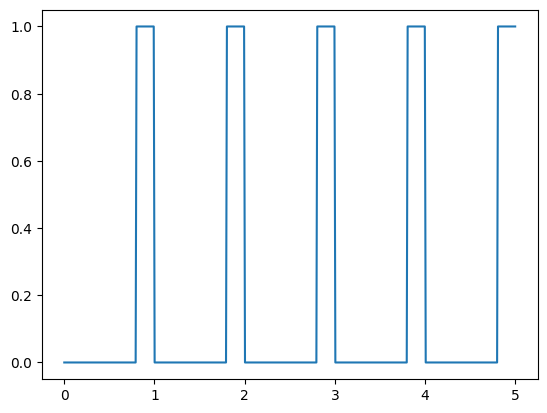

In [3]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

time_axis, exog = make_flashes(0, 5, [0]*80 + [1]*20, 5)
print(time_axis[0], time_axis[-1])
print(len(exog))
plt.plot(time_axis, exog)

In [4]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes[1:], weighted_stim, exp_stim
    return spikes

spikes_binned, weighted_stim, exp_stim = make_spikes(exog, 0.05, 0.7, return_exp=True)
print(len(spikes_binned))

499


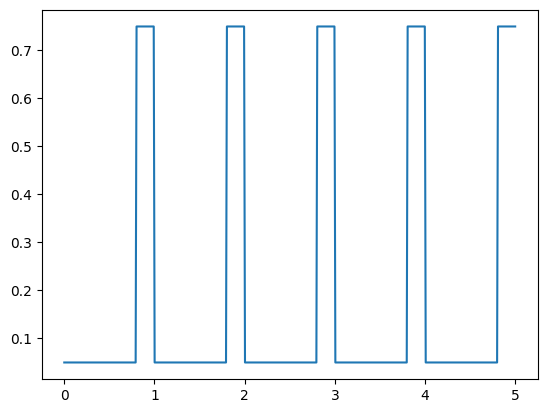

In [5]:
plt.plot(time_axis, weighted_stim)

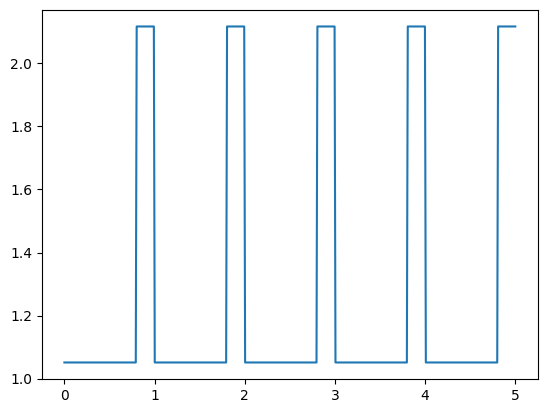

In [6]:
plt.plot(time_axis, exp_stim)

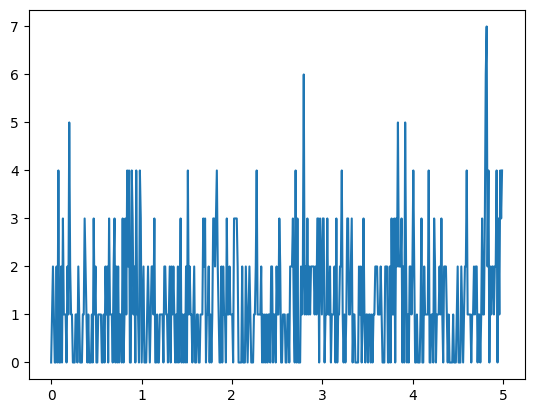

In [7]:
plt.plot(time_axis[:-1], spikes_binned)

### Design Matrix

In [8]:
# length of filter (# bins)
ntfilt = 1

In [9]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [10]:
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)

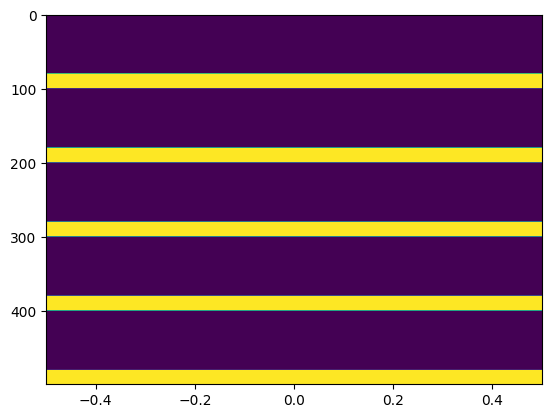

In [11]:
plt.imshow(design_mat, aspect="auto")

In [12]:
design_mat.shape

(499, 1)

### Class

In [13]:
def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    # vv = xx @ thetas  # filter output
    rr = np.exp(vv) * dt_bin  # conditional intensity (per bin)

    if len(np.where(np.isnan(rr))[0]) > 0:
        print('at GLM filter output')

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy;  # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term
    neglogli = Trm1 + Trm0

    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy  # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr  # non-spiking term
    dL = dL1 + dL0

    if len(np.where(np.isnan(dL0))[0]) > 0:
        print('At gradient')

    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr]))  # non-spiking term

    if len(np.where(np.isnan(H))[0]) > 0:
        print('At hessian')

    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]


In [14]:
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas
    grad = grad + Cinv @ thetas
    H = H + Cinv

    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return [neglogpost, grad, H][vals_to_return]

In [15]:
def fit(X, y, bin_sz=1, lam=8):
    # w0 = (X.T @ y) / np.sum(y)
    w0 = [0.05, 0.7]

    Imat = np.identity(X.shape[1])  # identity matrix of size of filter + const
    Imat[0, 0] = 0

    neglogli_func = lambda prs: neglogli_poissGLM(prs, X, y, bin_sz)

    Cinv = lam * Imat  # set inverse prior covariance
    loss_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=0)
    grad_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=1)
    hess_post_func = lambda prs: neglogposterior(prs, neglogli_func, Cinv, vals_to_return=2)
    optimizer = minimize(fun=loss_post_func, x0=w0, method='trust-ncg', jac=grad_post_func,
                            hess=hess_post_func,
                            tol=1e-6, options={'disp': False, 'maxiter': 100})
    return optimizer.x

### ALT MODEL

In [16]:
def make_design_matrix(stim, d=25):
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  return X

In [17]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  return -log_lik

In [38]:
def fit_lnp(stim, spikes, d=25):
# def fit(X, y, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """

  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim, d=d)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"]

### Generating Filters

In [39]:
# filters = []
# for i, spike_times in enumerate(units_spike_times):
#     spike_times = units_spike_times[i]
#     these_spikes_binned, _ = np.histogram(spike_times, time_axis)
#     try:
#         res = fit(design_mat_offset, these_spikes_binned, 100, lam=2**10)
#         const, filt = res[0], res[1:]
#         filters.append(filt)
#         print(i)
#     except:
#         filters.append([])

In [40]:
# n_cols=10

# n_rows = ceil(len(filters)/n_cols)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, n_rows))
# if len(axes.shape) == 1:
#     axes = axes.reshape((1, axes.shape[0]))

# for i in range(len(filters)):
#     f = filters[i]
#     row = i // n_cols
#     col = i % n_cols
#     axes[row][col].plot(f)
#     axes[row][col].set_ylabel(i)

# fig.tight_layout()
# plt.show()

In [41]:
# unit_idx = 134
# spike_times = units_spike_times[unit_idx]
# print(spike_times)

In [42]:
# num_spikes = len(time_axis)
# # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
# spikes_binned,_ = np.histogram(spike_times, time_axis)

### Binning spikes

In [43]:
# plt.plot(time_axis[:-1], spikes_binned)

### Fitting With Regularization

In [60]:
n_repeats = []
filters = []
constants = []
lambdas = []
bin_szs = []

repeat_trials = 13
lambda_trials = 10
bin_sz_trials = 10
for i in range(repeat_trials):
    # for j in range(lambda_trials):
    for j in range(10):
        print("i:",i,"j:",j)
        repeats = 2**i
        time_axis, exog = make_flashes(0, repeats, [0]*80 + [1]*20, repeats)
        spikes_binned = make_spikes(exog, 0.05, 0.7)
                
        ntfilt = 1
        num_time_bins = len(exog)-1
        design_mat = get_design_mat(ntfilt, exog, num_time_bins)
        design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

        print(design_mat_offset.shape, spikes_binned.shape)
        bs = 10 ** (j-5)/2
        res = fit(design_mat_offset, spikes_binned)
        print(design_mat_offset.shape)
        # res = fit_lnp(exog, spikes_binned, d=1)
        constant, filter = res[0], res[1:]
        n_repeats.append(2**i)
        # lambdas.append(0)
        # bin_szs.append(bs)
        filters.append(filter)
        constants.append(constant)

i: 0 j: 0
(99, 2) (100,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 99)

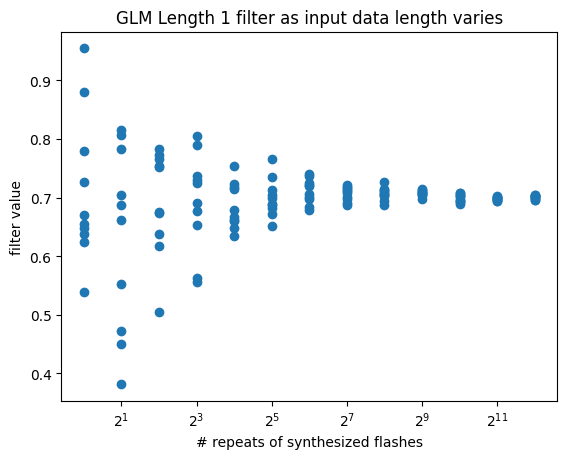

In [53]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Length 1 filter as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("filter value")
ax.scatter(n_repeats, filters)

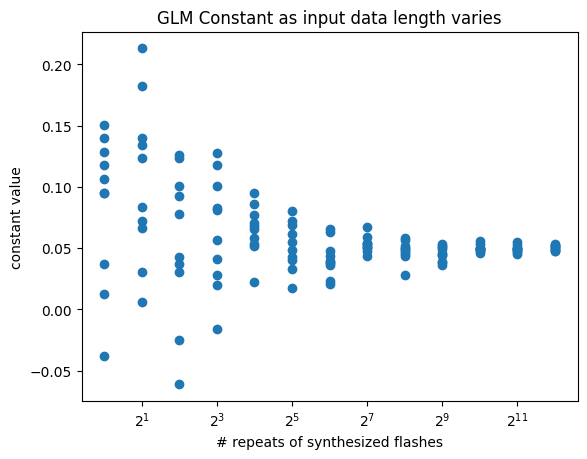

In [54]:
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_title("GLM Constant as input data length varies")
ax.set_xlabel("# repeats of synthesized flashes")
ax.set_ylabel("constant value")
ax.scatter(n_repeats, constants)

In [58]:
print(np.mean(constants), np.mean(filters))

0.058645782856197336 0.6958238276047312


### Predict Activity

In [55]:
time_axis, exog = make_flashes(0, 5000, [0]*80 + [1]*20, repeats)
spikes_binned = make_spikes(exog, 0.05, 0.7)

ntfilt = 1
num_time_bins = len(exog)-1
design_mat = get_design_mat(ntfilt, exog, num_time_bins)
design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones

res = fit(design_mat_offset, spikes_binned, bin_sz=0.01, lam=0)
constant, filter = res[0], res[1:]
print(constant, filter)

4.668069897924478 [0.65984099]


In [56]:
def predict(X, weights, constant, bin_sz=1):
    y = np.exp(X @ weights + constant) * bin_sz
    return y

def predict_spikes(X, weights, constant, bin_sz=1):
    rate = predict(X, weights, constant, bin_sz)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

In [57]:
### predict
predictions = []
for j in range(100):
    predictions.append(predict_spikes(design_mat, filter, constant))

-12033.200219843142
1.2639483983115194
126.38086274624693


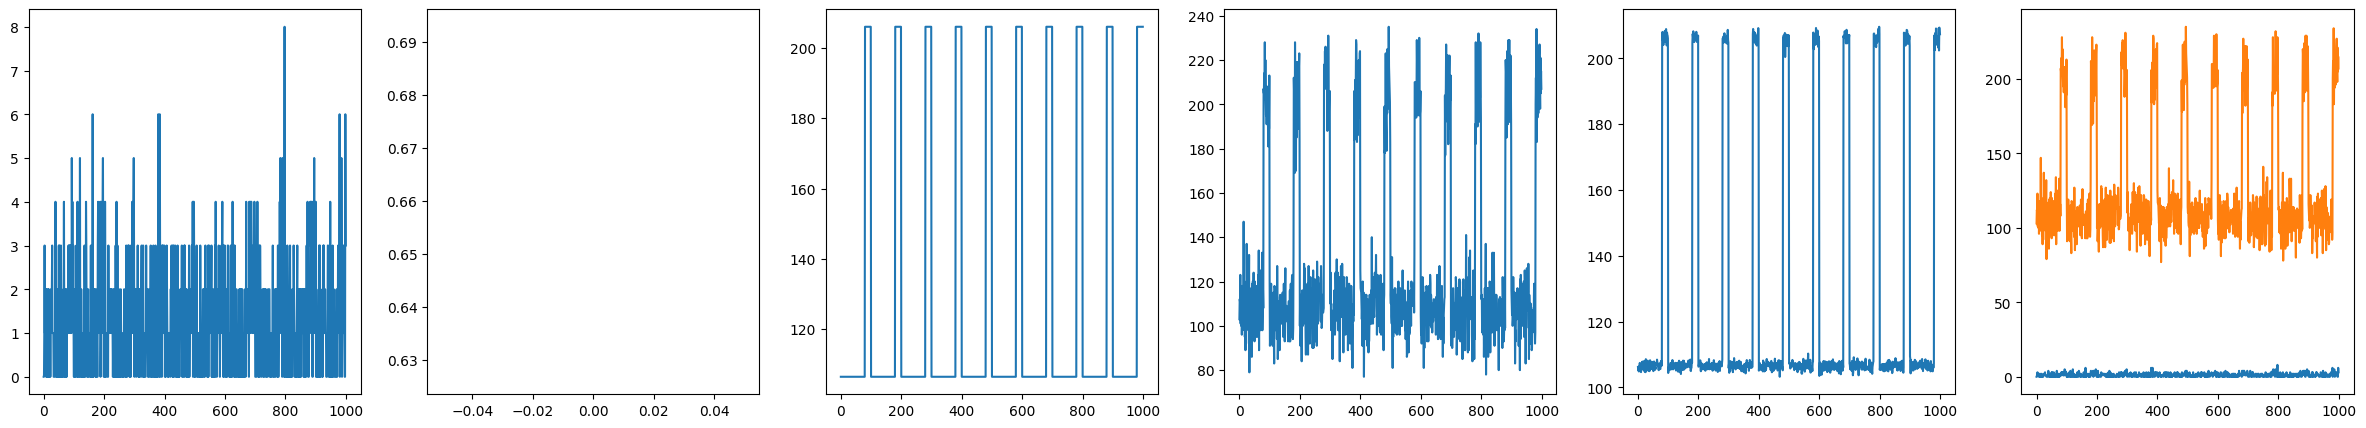

In [58]:
fig, axes = plt.subplots(1,6, figsize=(30,5))

prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
avg_predicted = np.mean(predictions, axis=0)

axes[0].plot(spikes_binned[0:1000])
axes[1].plot(filter)
axes[2].plot(prob_predicted[0:1000])
axes[3].plot(spikes_predicted[0:1000])
axes[4].plot(avg_predicted[0:1000])
axes[5].plot(spikes_binned[0:1000])
axes[5].plot(spikes_predicted[0:1000])

print(r2_score(spikes_binned, spikes_predicted))
print(np.sum(spikes_binned) / len(spikes_binned))
print(np.sum(spikes_predicted) / len(spikes_predicted))

plt.show()

In [59]:
mse2 = np.mean((spikes_binned-spikes_predicted)**2)  # mean squared error, with offset
rss = np.mean((spikes_binned-np.mean(spikes_binned))**2)    # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, w/ offset: {:.2f}'.format(1-mse2/rss))

Training perf (R^2): lin-gauss GLM, w/ offset: -12033.20


In [60]:
# # %matplotlib

# fig, axes = plt.subplots(20,6, figsize=(30,30))
# for i in range(20):
#     t = 120
#     unit_idx = 120+i
#     spike_times = units_spike_times[unit_idx]

#     num_spikes = len(time_axis)
#     # spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
#     spikes_binned,_ = np.histogram(spike_times, time_axis)

#     ### fit
#     design_mat_offset = np.hstack((np.ones((design_mat.shape[0],1)), design_mat)) # just add a column of ones
#     res = fit(design_mat_offset, spikes_binned, lam=2**10)
#     constant, filter = res[0], res[1:]

#     ### predict
#     predictions = []
#     for j in range(1000):
#         predictions.append(predict_spikes(design_mat, filter, constant))

#     prob_predicted = predict(design_mat, filter, constant, bin_sz=1)
#     spikes_predicted = predict_spikes(design_mat, filter, constant, bin_sz=1)
#     avg_predicted = np.mean(predictions, axis=0)

#     axes[i][0].plot(spikes_binned[20000:30000])
#     axes[i][1].plot(filter)
#     axes[i][2].plot(prob_predicted[20000:30000])
#     axes[i][3].plot(spikes_predicted[20000:30000])
#     axes[i][4].plot(avg_predicted[20000:30000], lw=0.05)
#     axes[i][5].plot(spikes_binned[20000:30000])
#     axes[i][5].plot(spikes_predicted[20000:30000])

#     print(i, r2_score(spikes_binned, spikes_predicted))

# plt.show()